In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import os
img_path = "/content/drive/My Drive/Data_ASL/asl_dataset/0/hand1_0_bot_seg_1_cropped.jpeg"
print(os.path.exists(img_path))

True


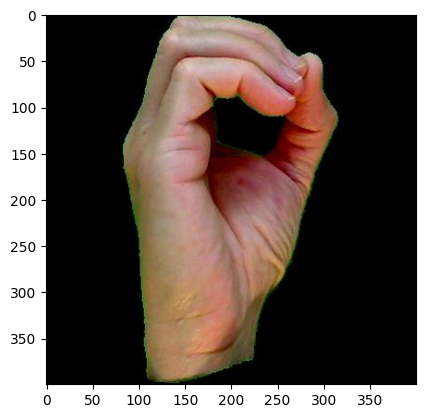

In [11]:
from PIL import Image

imagen = Image.open(img_path)

import matplotlib.pyplot as plt
plt.imshow(imagen)

# Loading and Preprocessing the ASL Dataset

The ASL dataset is organized into folders named `0-9` and `a-z`, each containing images of hand gestures corresponding to those labels. We'll use these folders to load images, preprocess them (resize to 28x28 pixels, convert to grayscale, and normalize pixel values), and split them into training, validation, and testing datasets.


In [12]:
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image

# Step 1: Define the dataset path
# This is the folder where your ASL dataset is stored.
data_dir = "/content/drive/My Drive/Data_ASL/asl_dataset"

# Step 2: Define the dimensions for resizing the images
# All images will be resized to 28x28 pixels to make them uniform.
img_height, img_width = 28, 28

# Step 3: Initialize empty lists for storing image data and labels
data = []  # To store the image arrays (pixels)
labels = []  # To store the corresponding class labels (0-9 and a-z)

# Step 4: Loop through each folder in the dataset
# Each folder corresponds to a class (e.g., 0, 1, a, b, etc.).
for label, folder_name in enumerate(sorted(os.listdir(data_dir))):
    folder_path = os.path.join(data_dir, folder_name)  # Full path to the folder
    if os.path.isdir(folder_path):  # Make sure it's a folder, not a file
        for file_name in os.listdir(folder_path):  # Loop through each file in the folder
            file_path = os.path.join(folder_path, file_name)  # Full path to the image
            try:
                # Step 5: Load the image
                # Convert the image to grayscale and resize it to 28x28 pixels
                img = Image.open(file_path).convert("L")  # "L" mode converts to grayscale
                img = img.resize((img_height, img_width))  # Resize the image

                # Step 6: Normalize the image pixels
                # Convert image to a NumPy array and scale pixel values to [0, 1]
                img_array = np.array(img) / 255.0
                data.append(img_array)  # Add the processed image to the data list
                labels.append(label)  # Add the class label to the labels list
            except Exception as e:
                # If there's an error loading an image, print the error message
                print(f"Error loading image {file_path}: {e}")

# Step 7: Convert data and labels to NumPy arrays
# This makes it easier to work with the data in TensorFlow.
data = np.array(data, dtype="float32")  # Convert list of images to a NumPy array
labels = np.array(labels)  # Convert list of labels to a NumPy array

# Step 8: Reshape the data
# Add a channel dimension for TensorFlow (required for grayscale images).
data = np.expand_dims(data, axis=-1)  # Shape becomes (samples, 28, 28, 1)

# Step 9: Split the data into training, validation, and testing sets
# Use 70% of the data for training, and split the remaining 30% evenly into validation and test sets.
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 10: Print the shapes of the datasets
# This helps verify that the data is split correctly.
print(f"Training data shape: {X_train.shape}")  # Shape of the training set
print(f"Validation data shape: {X_valid.shape}")  # Shape of the validation set
print(f"Test data shape: {X_test.shape}")  # Shape of the test set

# You are splitting the data into 70% training, 15% validation, and 15% testing.
# The shapes (28, 28, 1) correspond to grayscale images resized to 28x28 pixels with a single channel (1).

Training data shape: (1760, 28, 28, 1)
Validation data shape: (377, 28, 28, 1)
Test data shape: (378, 28, 28, 1)


# Visualizing the ASL Dataset

To ensure the dataset is loaded correctly, we'll visualize a few images from the training set along with their labels.


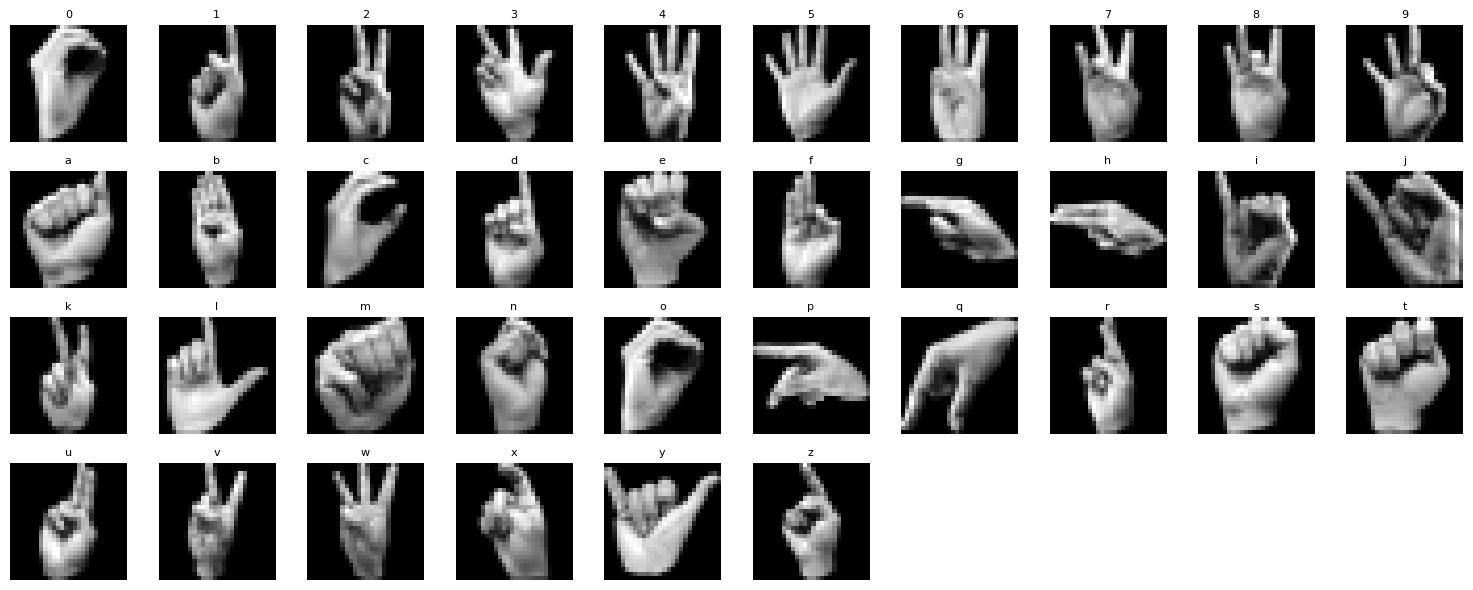

In [13]:
import matplotlib.pyplot as plt

# Step 1: Define the class names
# These represent the labels for the ASL dataset, covering digits (0-9) and letters (a-z).
class_names = list(map(str, range(10))) + list("abcdefghijklmnopqrstuvwxyz")

# Step 2: Prepare for ordered visualization
# We want to display one sample image for each class (0-9 and a-z) in the correct order.

# Initialize a list to store the indices of images in the correct class order
ordered_indices = []

# Loop through all the classes (0-9 and a-z)
for i in range(len(class_names)):
    # Find the first occurrence of each class in the training labels
    idx = np.where(y_train == i)[0][0]  # Get the first index where the label equals the class
    ordered_indices.append(idx)  # Add this index to the ordered list

# Step 3: Set up the grid for visualization
# We will display the images in a grid with 4 rows and 10 columns.
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))  # Adjust figure size for better display

# Loop through the ordered indices to plot images
for i, idx in enumerate(ordered_indices):
    plt.subplot(n_rows, n_cols, i + 1)  # Create a subplot for each image
    plt.imshow(X_train[idx].reshape(img_height, img_width), cmap="gray")  # Show the image
    plt.axis("off")  # Turn off axis ticks and labels for clarity
    plt.title(class_names[y_train[idx]], fontsize=8)  # Add the class label as the title

# Step 4: Adjust layout and display the plot
plt.tight_layout()  # Adjust spacing between subplots
plt.show()  # Display the grid of images


# Building the Neural Network

Now that the dataset is preprocessed and visualized, we will build a neural network for the ASL classification task.
The model will consist of the following layers:
1. **Input Layer**: Accepts flattened grayscale images of shape (28x28).
2. **Hidden Layers**: Two fully connected layers with 300 and 100 neurons, using the ReLU activation function.
3. **Output Layer**: A softmax layer with 36 neurons (one for each class, 0-9 and a-z) to output class probabilities.

The ReLU activation function introduces non-linearity, helping the model learn complex patterns, while the softmax activation is ideal for multi-class classification.


In [14]:
from tensorflow.keras import models, layers

# Step 1: Initialize the model
# Sequential means the layers will be added one after another in order.
model = models.Sequential()

# Step 2: Add a flattening layer
# Converts each 28x28 grayscale image into a 1D array of 784 pixels for input into the neural network.
model.add(layers.Flatten(input_shape=(28, 28, 1)))

# Step 3: Add the first hidden layer
# This layer has 300 neurons and uses the ReLU activation function.
# ReLU stands for "Rectified Linear Unit," which helps the model learn complex features.
model.add(layers.Dense(300, activation="relu"))

# Step 4: Add the second hidden layer
# This layer has 100 neurons and also uses the ReLU activation function.
# Adding multiple layers allows the model to learn hierarchical representations.
model.add(layers.Dense(100, activation="relu"))

# Step 5: Add the output layer
# This layer has 36 neurons (one for each class, 0-9 and a-z).
# The softmax activation function converts the outputs into probabilities, summing to 1.
model.add(layers.Dense(36, activation="softmax"))

# Step 6: Print the model summary
# This provides an overview of the model architecture, including the number of parameters in each layer.
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 300)                 │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 36)                  │           3,636 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 269,236 (1.03 MB)

 Trainable params: 269,236 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

# Compiling the Neural Network

Before training the model, we need to specify:
1. **Loss Function**: `sparse_categorical_crossentropy` is used for multi-class classification tasks when labels are integers (e.g., 0-35 for ASL classes).
2. **Optimizer**: `adam` is an adaptive learning rate optimizer that works well for most use cases, including this one.
3. **Metrics**: We will track `accuracy` during training to monitor how well the model is performing.


In [15]:
# Step 1: Compile the model
# Compile defines the loss function, optimizer, and evaluation metrics for training.
model.compile(
    loss="sparse_categorical_crossentropy",  # Loss function for multi-class classification
    optimizer="adam",  # Adam optimizer for efficient weight updates
    metrics=["accuracy"]  # Track accuracy during training
)

# Step 2: Print confirmation
# This indicates the model is ready for training.
print("Model compiled successfully.")


Model compiled successfully.


# Training the Neural Network

We will train the model using the preprocessed ASL dataset:
1. **Training Data**: 70% of the dataset is used for training the model.
2. **Validation Data**: 15% of the dataset is used for validation during training to monitor the model's performance on unseen data.
3. **Epochs**: The model will iterate over the entire training dataset 20 times to adjust its weights.
4. **Batch Size**: Training will be performed in batches of 100 images at a time to balance memory usage and convergence speed.

The training history will be stored for visualization and analysis.


In [16]:
# Step 1: Train the model
# Fit the model to the training data, using validation data to monitor performance.
history = model.fit(
    X_train,  # Input training data
    y_train,  # Training labels
    epochs=20,  # Number of times the model sees the entire training dataset
    batch_size=100,  # Number of samples per training batch
    validation_data=(X_valid, y_valid)  # Validation data for performance monitoring
)

# Step 2: Print confirmation
# This indicates the training process is complete.
print("Model training completed.")


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.1672 - loss: 3.2793 - val_accuracy: 0.5332 - val_loss: 2.2956
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6061 - loss: 1.9687 - val_accuracy: 0.7135 - val_loss: 1.2465
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7754 - loss: 1.0995 - val_accuracy: 0.8249 - val_loss: 0.8291
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8274 - loss: 0.7080 - val_accuracy: 0.8700 - val_loss: 0.5731
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8965 - loss: 0.5086 - val_accuracy: 0.8488 - val_loss: 0.5029
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8980 - loss: 0.4206 - val_accuracy: 0.8806 - val_loss: 0.4228
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9217 - loss: 0.3187 - val_accuracy: 0.8727 - val_loss: 0.3738
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9241 - loss: 0.2959 - val_accuracy: 0.8992 - v

# Evaluating the Neural Network

After training, we will evaluate the model's performance on the testing dataset to determine:
1. **Loss**: The difference between predicted and actual labels.
2. **Accuracy**: The percentage of correctly classified images in the testing dataset.


In [17]:
# Step 1: Evaluate the model on the test dataset
# This measures the model's performance on unseen data.
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Step 2: Print evaluation results
# Show the total loss and accuracy on the test dataset.
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9391 - loss: 0.1951 
Test Loss: 0.19749674201011658
Test Accuracy: 0.9338624477386475


# Visualizing Training History

To better understand how the model performed during training, we will plot:
1. **Training vs. Validation Accuracy**: Shows how accuracy improved over epochs.
2. **Training vs. Validation Loss**: Shows how the loss decreased over epochs.

This helps us determine if the model is overfitting (training accuracy is much higher than validation accuracy).


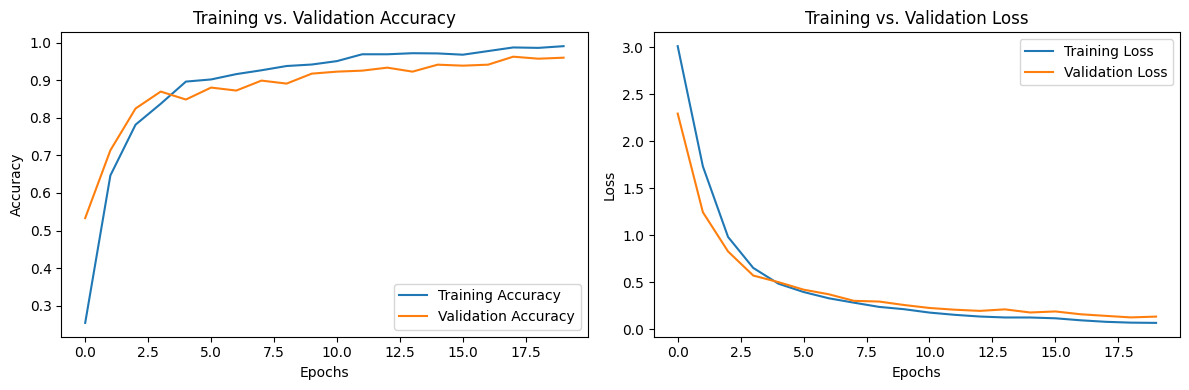

In [18]:
import matplotlib.pyplot as plt

# Step 1: Plot Training and Validation Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)  # First plot
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy")
plt.legend()

# Step 2: Plot Training and Validation Loss
plt.subplot(1, 2, 2)  # Second plot
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()

# Step 3: Display the plots
plt.tight_layout()
plt.show()


# Making Predictions with the Neural Network

Now that the model has been trained and evaluated, we will use it to make predictions on unseen test images.
This involves:
1. Using the `predict` method to calculate the probability of each class for a given input.
2. Identifying the class with the highest probability as the predicted label.
3. Comparing the predicted label to the actual label to check accuracy visually.


In [19]:
# Step 1: Use the model to predict the class probabilities for the first 10 test images
predictions = model.predict(X_test[:10])  # Predict probabilities for 10 test images

# Step 2: Convert probabilities into predicted class labels
# np.argmax finds the index of the maximum probability for each prediction
predicted_classes = np.argmax(predictions, axis=1)

# Step 3: Print the predicted and actual labels
# Compare predictions with the true labels in the test dataset
print("Predicted classes:", [class_names[i] for i in predicted_classes])
print("Actual labels:", [class_names[i] for i in y_test[:10]])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted classes: ['6', 'n', 'n', 'o', 'r', 'x', '3', 'a', 'r', '5']
Actual labels: ['6', 'n', 'n', 'o', 'r', 'x', '3', 'a', 'r', '5']


# Visualizing Predictions

To better understand how well the model performs, we will:
1. Display the first 10 test images.
2. Show the model's predicted labels and the actual labels.
3. Highlight whether each prediction is correct or incorrect.


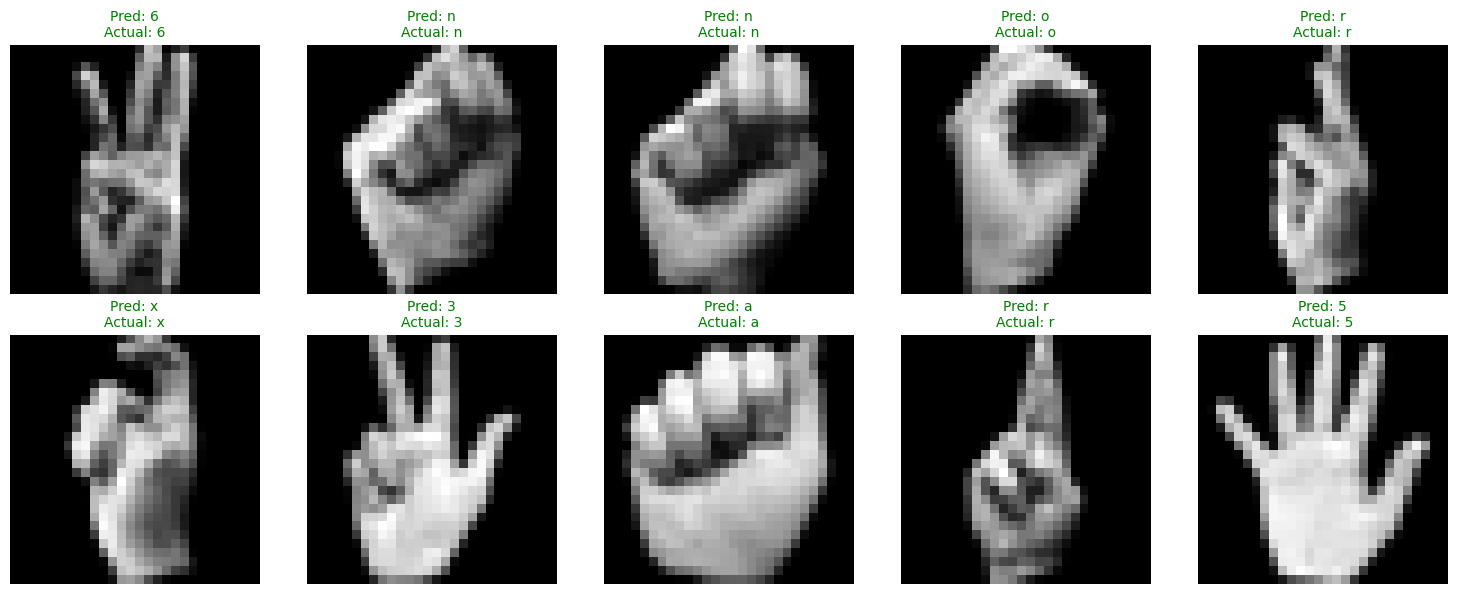

In [20]:
# Step 1: Set up the grid for displaying images
plt.figure(figsize=(15, 6))  # Adjust figure size
n_images = 10  # Number of images to display

# Step 2: Loop through the first 10 test images
for i in range(n_images):
    plt.subplot(2, 5, i + 1)  # Create a subplot (2 rows, 5 columns)
    plt.imshow(X_test[i].reshape(img_height, img_width), cmap="gray")  # Display the image
    plt.axis("off")  # Turn off axis for clarity

    # Step 3: Add title to indicate prediction and correctness
    color = "green" if predicted_classes[i] == y_test[i] else "red"  # Green if correct, red if incorrect
    plt.title(
        f"Pred: {class_names[predicted_classes[i]]}\nActual: {class_names[y_test[i]]}",
        fontsize=10, color=color
    )

# Step 4: Display the grid of images
plt.tight_layout()
plt.show()


# Generating a Confusion Matrix

To better understand the model's performance, we will create a confusion matrix:
1. The rows represent the actual labels (ground truth).
2. The columns represent the predicted labels.
3. Each cell shows the number of times the model predicted a specific class for a given true class.

This visualization helps us identify where the model is performing well and where it might be misclassifying.


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


<Figure size 1500x1500 with 0 Axes>

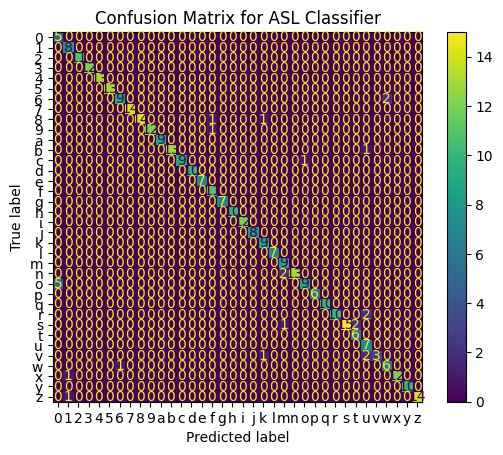

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Predict class labels for the entire test dataset
# Use np.argmax to convert probabilities to class predictions
y_pred = np.argmax(model.predict(X_test), axis=1)

# Step 2: Create a confusion matrix
# Rows: actual labels (y_test), Columns: predicted labels (y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Step 3: Display the confusion matrix as a heatmap
# Use ConfusionMatrixDisplay for better visualization
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
plt.figure(figsize=(15, 15))  # Adjust figure size for clarity
disp.plot(cmap="viridis", colorbar=True)
plt.title("Confusion Matrix for ASL Classifier")
plt.show()


# Analyzing Misclassified Examples

We will now examine the cases where the model made incorrect predictions:
1. Identify the indices of misclassified test images.
2. Display a subset of these images alongside their actual and predicted labels.
3. Highlight patterns in misclassifications to improve the model in future iterations.


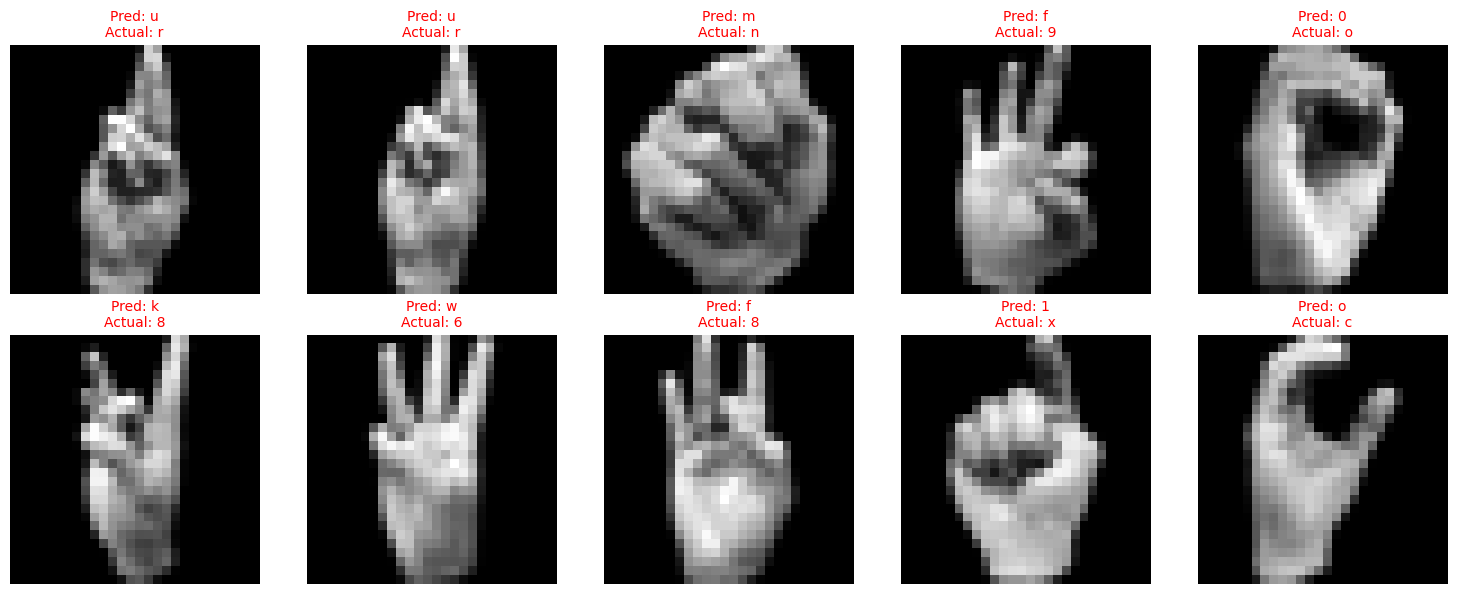

In [23]:
# Step 1: Identify misclassified examples
# A misclassification occurs when the predicted label does not match the actual label
misclassified_indices = np.where(y_pred != y_test)[0]

# Step 2: Display a few misclassified images
n_misclassified = min(10, len(misclassified_indices))  # Display up to 10 misclassified examples
plt.figure(figsize=(15, 6))  # Adjust figure size

for i in range(n_misclassified):
    idx = misclassified_indices[i]  # Get the index of the misclassified image
    plt.subplot(2, 5, i + 1)  # Create a subplot (2 rows, 5 columns)
    plt.imshow(X_test[idx].reshape(img_height, img_width), cmap="gray")  # Display the image
    plt.axis("off")  # Turn off axis for clarity

    # Step 3: Add title with actual and predicted labels
    plt.title(
        f"Pred: {class_names[y_pred[idx]]}\nActual: {class_names[y_test[idx]]}",
        fontsize=10, color="red"  # Use red text to indicate misclassification
    )

# Step 4: Display the grid of images
plt.tight_layout()
plt.show()


# Saving the Trained Model

Once the model is trained and evaluated, we save it to a file so that it can be reused later without retraining. This is especially useful for deploying the model or sharing it with others.


In [24]:
# Step 1: Define the file path for saving the model
# This will save the model in the current working directory as a TensorFlow .h5 file.
model_save_path = "asl_classifier_model.h5"

# Step 2: Save the trained model
# The save method writes the model architecture, weights, and optimizer configuration to the file.
model.save(model_save_path)

# Step 3: Print confirmation
# This message confirms that the model has been saved successfully.
print(f"Model saved to {model_save_path}")


Model saved to asl_classifier_model.h5
